In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import utils

random_wav = "bass_electronic_018-022-100.wav"


audio = utils.load_audio(random_wav)
sample_length = audio.shape[0]
print(sample_length)
audio = np.concatenate((audio, audio))
 

64000


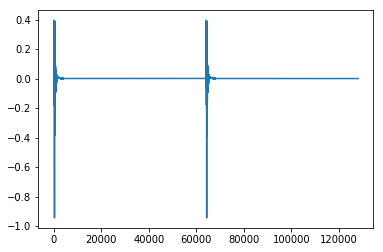

In [3]:
%matplotlib inline
plt.plot(audio)
plt.show()

In [4]:
print(audio)

[  0.00000000e+00   6.10351562e-05   2.13623047e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


In [6]:
def mul_or_none(a, b):
  """Return the element wise multiplicative of the inputs.

  If either input is None, we return None.

  Args:
    a: A tensor input.
    b: Another tensor input with the same type as a.

  Returns:
    None if either input is None. Otherwise returns a * b.
  """
  if a is None or b is None:
    return None
  return a * b

def time_to_batch(x, block_size):
  """Splits time dimension (i.e. dimension 1) of `x` into batches.

  Within each batch element, the `k*block_size` time steps are transposed,
  so that the `k` time steps in each output batch element are offset by
  `block_size` from each other.

  The number of input time steps must be a multiple of `block_size`.

  Args:
    x: Tensor of shape [nb, k*block_size, n] for some natural number k.
    block_size: number of time steps (i.e. size of dimension 1) in the output
      tensor.

  Returns:
    Tensor of shape [nb*block_size, k, n]
  """
  shape = x.get_shape().as_list()
  y = tf.reshape(x, [
      shape[0], shape[1] // block_size, block_size, shape[2]
  ])
  y = tf.transpose(y, [0, 2, 1, 3])
  y = tf.reshape(y, [
      shape[0] * block_size, shape[1] // block_size, shape[2]
  ])
  y.set_shape([
      mul_or_none(shape[0], block_size), mul_or_none(shape[1], 1. / block_size),
      shape[2]
  ])
  return y


def batch_to_time(x, block_size):
  """Inverse of `time_to_batch(x, block_size)`.

  Args:
    x: Tensor of shape [nb*block_size, k, n] for some natural number k.
    block_size: number of time steps (i.e. size of dimension 1) in the output
      tensor.

  Returns:
    Tensor of shape [nb, k*block_size, n].
  """
  shape = x.get_shape().as_list()
  y = tf.reshape(x, [shape[0] // block_size, block_size, shape[1], shape[2]])
  y = tf.transpose(y, [0, 2, 1, 3])
  y = tf.reshape(y, [shape[0] // block_size, shape[1] * block_size, shape[2]])
  y.set_shape([mul_or_none(shape[0], 1. / block_size),
               mul_or_none(shape[1], block_size),
               shape[2]])
  return y



In [1]:
import tensorflow as tf
learning_rate = 0.00001
num_lstm = 512
with tf.Graph().as_default():
    #session_config = tf.Config
    with tf.Session() as sess:
        lstm = tf.contrib.rnn.BasicLSTMCell(num_lstm)
        #initial_state = tf.zeros([batch_size, lstm.state_size])
        
#encode with 8 bit mu-law
x = audio
x_quantized = utils.mu_law(x)
x_scaled = tf.cast(x_quantized, tf.float32) / 128.0
#x_scaled = tf.expand_dims(x_scaled, 2)
num_z = 16
print(x_scaled)

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


NameError: name 'audio' is not defined

In [40]:
num_layers = 1
num_steps = 1
input_size = 1
lstm_size = 128
keep_prob = 1
stock_count = 1
embed_size = 1

In [51]:
tf.reset_default_graph()

#official tutorial: words_in_dataset = tf.placeholder(tf.float32, [time_steps, batch_size, num_features])
learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")
# symbols are mapped to integers.
symbols = tf.placeholder(tf.int32, [None, 1], name='symbols')
#inputs = tf.placeholder(tf.float32, [None, num_steps, input_size], name="inputs")
inputs = tf.placeholder(tf.float32, [None], name="inputs")
inputs = tf.reshape(inputs, tf.TensorShape([64000,1,1]))
targets = tf.placeholder(tf.float32, [None, input_size], name="targets")

def _create_one_cell():
    lstm_cell = tf.contrib.rnn.LSTMCell(lstm_size, state_is_tuple=True)
    '''
    if keep_prob < 1.0:
        lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)    '''
    return lstm_cell

cell = tf.contrib.rnn.MultiRNNCell([_create_one_cell() for _ in range(num_layers)],state_is_tuple=True
) if num_layers > 1 else _create_one_cell()


#embedding layer
embed_matrix = tf.Variable(
    tf.random_uniform([stock_count, embed_size], -1.0, 1.0),
    name="embed_matrix"
)
sym_embeds = tf.nn.embedding_lookup(embed_matrix, symbols)
            
# stock_label_embeds.shape = (batch_size, embedding_size)
stacked_symbols = tf.tile(symbols, [1, num_steps], name='stacked_stock_labels')
stacked_embeds = tf.nn.embedding_lookup(embed_matrix, stacked_symbols)

# After concat, inputs.shape = (batch_size, num_steps, lstm_size + embed_size)
inputs_with_embed = tf.concat([inputs, stacked_embeds], axis=2, name="inputs_with_embed")

val, state_ = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32, scope="dynamic_rnn")

# Before transpose, val.get_shape() = (batch_size, num_steps, lstm_size)
# After transpose, val.get_shape() = (num_steps, batch_size, lstm_size)
val = tf.transpose(val, [1, 0, 2])
last = tf.gather(val, int(val.get_shape()[0]) - 1, name="lstm_state")
ws = tf.Variable(tf.truncated_normal([lstm_size, input_size]), name="w")
bias = tf.Variable(tf.constant(0.1, shape=[input_size]), name="b")
pred = tf.matmul(last, ws) + bias

loss = tf.reduce_mean(tf.square(pred - targets), name="loss_mse")
optim = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, name="rmsprop_optim")

In [74]:
audio = utils.load_audio(random_wav)
audio = list(map(lambda x: x, audio))
np.array(audio)

import numpy as np
import pandas as pd
import random


class dt():
    def __init__(self, raw_audio, input_size = input_size, num_steps = num_steps, test_ratio = 0.1, normalized = True):
        self.raw_seq = np.array(raw_audio)
        self.input_size = input_size
        self.num_steps = num_steps 
        self.test_ratio = test_ratio
        self.normalized = normalized
        self.train_X, self.train_y, self.test_X, self.test_y = self._prepare_data(self.raw_seq)

    def _prepare_data(self, seq):
        # split into items of input_size
        seq = [np.array(seq[i * self.input_size: (i + 1) * self.input_size])
               for i in range(len(seq) // self.input_size)]

        if self.normalized:
            seq = [seq[0] / seq[0][0] - 1.0] + [
                curr / seq[i][-1] - 1.0 for i, curr in enumerate(seq[1:])]

        # split into groups of num_steps
        X = np.array([seq[i: i + self.num_steps] for i in range(len(seq) - self.num_steps)])
        y = np.array([seq[i + self.num_steps] for i in range(len(seq) - self.num_steps)])

        train_size = int(len(X) * (1.0 - self.test_ratio))
        train_X, test_X = X[:train_size], X[train_size:]
        train_y, test_y = y[:train_size], y[train_size:]
        return train_X, train_y, test_X, test_y

    def generate_one_epoch(self, batch_size):
        num_batches = int(len(self.train_X)) // batch_size
        if batch_size * num_batches < len(self.train_X):
            num_batches += 1

        batch_indices = range(num_batches)
        random.shuffle(batch_indices)
        for j in batch_indices:
            batch_X = self.train_X[j * batch_size: (j + 1) * batch_size]
            batch_y = self.train_y[j * batch_size: (j + 1) * batch_size]
            assert set(map(len, batch_X)) == {self.num_steps}
            yield batch_X, batch_y

d = dt(audio)
d.generate_one_epoch(100)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


<generator object dt.generate_one_epoch at 0x7f455407e0a0>

In [62]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    merged_test_labels = [1] * len(audio)
    merged_test_X = np.array(audio)
    merged_test_y = np.array(audio)
    merged_test_labels = np.array(merged_test_labels)
    train_data_feed = {
            inputs: merged_test_X,
            targets: merged_test_y,
            symbols: merged_test_labels,
        }
    train_loss, _ = sess.run([loss, optim], train_data_feed)
    print(train_loss)

ValueError: Cannot feed value of shape (64000,) for Tensor 'Reshape:0', which has shape '(64000, 1, 1)'

In [6]:
class LstmRNN(object):
    def __init__(self, sess, stock_count,
                 lstm_size=128,
                 num_layers=1,
                 num_steps=30,
                 input_size=1,
                 keep_prob=0.8,
                 embed_size=None,
                 logs_dir="logs",
                 plots_dir="images"):
        """
        Construct a RNN model using LSTM cell.

        Args:
            sess:
            stock_count:
            lstm_size:
            num_layers
            num_steps:
            input_size:
            keep_prob:
            embed_size
            checkpoint_dir
        """
        self.sess = sess
        self.stock_count = stock_count

        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.num_steps = num_steps
        self.input_size = input_size
        self.keep_prob = keep_prob

        self.use_embed = (embed_size is not None) and (embed_size > 0)
        self.embed_size = embed_size or -1

        self.logs_dir = logs_dir
        self.plots_dir = plots_dir

        self.build_graph()

    def train(self, dataset_list, config):
        """
        Args:
            dataset_list (<StockDataSet>)
            config (tf.app.flags.FLAGS)
        """

        tf.global_variables_initializer().run()

        # Merged test data of different stocks.
        merged_test_X = []
        merged_test_y = []
        merged_test_labels = []

        for label_, d_ in enumerate(dataset_list):
            merged_test_X += list(d_.test_X)
            merged_test_y += list(d_.test_y)
            merged_test_labels += [[label_]] * len(d_.test_X)

        merged_test_X = np.array(merged_test_X)
        merged_test_y = np.array(merged_test_y)
        merged_test_labels = np.array(merged_test_labels)

        print "len(merged_test_X) =", len(merged_test_X)
        print "len(merged_test_y) =", len(merged_test_y)
        print "len(merged_test_labels) =", len(merged_test_labels)

        test_data_feed = {
            self.learning_rate: 0.0,
            self.inputs: merged_test_X,
            self.targets: merged_test_y,
            self.symbols: merged_test_labels,
        }

        global_step = 0

        num_batches = sum(len(d_.train_X) for d_ in dataset_list) // config.batch_size
        random.seed(time.time())

        # Select samples for plotting.
        sample_labels = range(min(config.sample_size, len(dataset_list)))
        sample_indices = {}
        for l in sample_labels:
            sym = dataset_list[l].stock_sym
            target_indices = np.array([
                i for i, sym_label in enumerate(merged_test_labels)
                if sym_label[0] == l])
            sample_indices[sym] = target_indices
        print sample_indices

        print "Start training for stocks:", [d.stock_sym for d in dataset_list]
        for epoch in xrange(config.max_epoch):
            epoch_step = 0
            learning_rate = config.init_learning_rate * (
                config.learning_rate_decay ** max(float(epoch + 1 - config.init_epoch), 0.0)
            )

            for label_, d_ in enumerate(dataset_list):
                for batch_X, batch_y in d_.generate_one_epoch(config.batch_size):
                    global_step += 1
                    epoch_step += 1
                    batch_labels = np.array([[label_]] * len(batch_X))
                    train_data_feed = {
                        self.learning_rate: learning_rate,
                        self.inputs: batch_X,
                        self.targets: batch_y,
                        self.symbols: batch_labels,
                    }
                    train_loss, _, train_merged_sum = self.sess.run(
                        [self.loss, self.optim, self.merged_sum], train_data_feed)
                    self.writer.add_summary(train_merged_sum, global_step=global_step)

                    if np.mod(global_step, len(dataset_list) * 100 / config.input_size) == 1:
                        test_loss, test_pred = self.sess.run([self.loss, self.pred], test_data_feed)

                        print "Step:%d [Epoch:%d] [Learning rate: %.6f] train_loss:%.6f test_loss:%.6f" % (
                            global_step, epoch, learning_rate, train_loss, test_loss)

                        # Plot samples
                        for sample_sym, indices in sample_indices.iteritems():
                            image_path = os.path.join(self.model_plots_dir, "{}_epoch{:02d}_step{:04d}.png".format(
                                sample_sym, epoch, epoch_step))
                            sample_preds = test_pred[indices]
                            sample_truth = merged_test_y[indices]
                            self.plot_samples(sample_preds, sample_truth, image_path, stock_sym=sample_sym)

                        self.save(global_step)

        final_pred, final_loss = self.sess.run([self.pred, self.loss], test_data_feed)

        # Save the final model
        self.save(global_step)
        return final_pred

    @property
    def model_name(self):
        name = "stock_rnn_lstm%d_step%d_input%d" % (
            self.lstm_size, self.num_steps, self.input_size)

        if self.embed_size > 0:
            name += "_embed%d" % self.embed_size

        return name

    @property
    def model_logs_dir(self):
        model_logs_dir = os.path.join(self.logs_dir, self.model_name)
        if not os.path.exists(model_logs_dir):
            os.makedirs(model_logs_dir)
        return model_logs_dir

    @property
    def model_plots_dir(self):
        model_plots_dir = os.path.join(self.plots_dir, self.model_name)
        if not os.path.exists(model_plots_dir):
            os.makedirs(model_plots_dir)
        return model_plots_dir

    def save(self, step):
        model_name = self.model_name + ".model"
        self.saver.save(
            self.sess,
            os.path.join(self.model_logs_dir, model_name),
            global_step=step
        )

    def load(self):
        print(" [*] Reading checkpoints...")
        ckpt = tf.train.get_checkpoint_state(self.model_logs_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(self.model_logs_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
            print(" [*] Success to read {}".format(ckpt_name))
            return True, counter

        else:
            print(" [*] Failed to find a checkpoint")
            return False, 0

    def plot_samples(self, preds, targets, figname, stock_sym=None):
        def _flatten(seq):
            return [x for y in seq for x in y]

        truths = _flatten(targets)[-200:]
        preds = _flatten(preds)[-200:]
        days = range(len(truths))[-200:]

        plt.figure(figsize=(12, 6))
        plt.plot(days, truths, label='truth')
        plt.plot(days, preds, label='pred')
        plt.legend(loc='upper left', frameon=False)
        plt.xlabel("day")
        plt.ylabel("normalized price")
        plt.ylim((min(truths), max(truths)))
        plt.grid(ls='--')

        if stock_sym:
            plt.title(stock_sym + " | Last %d days in test" % len(truths))

        plt.savefig(figname, format='png', bbox_inches='tight', transparent=True)
        plt.close()

Tensor("truediv_3:0", shape=(128000,), dtype=float32)
